In the other notebook I documented how I merged the tables from several PDFs in order to have a reasonable dataframe available. At this point I continue to work with the self-created csv file.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import squarify

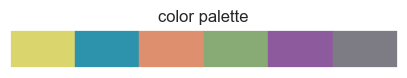

In [2]:
sns.set()

c_pal = ["#DBD56E","#2D93AD","#DE8F6E","#88AB75",'#8D5A9E', "#7D7C84"]

fig, ax = plt.subplots(figsize=(5, 0.5))

for i, color in enumerate(c_pal):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(c_pal))
ax.set_ylim(0, 1)

ax.set_xticks([])
ax.set_yticks([])

plt.title('color palette')

plt.show();

In [3]:
data = pd.read_csv('data/plaenterwaldlauf.csv')

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data.head()

,Startnr.,AK,Platz AK,Verein,Bruttozeit,Nettozeit,Strecke
0,605,M 20,1,TuS Kreuzweingarten-Rheder,17:16 min,(17:15),5
1,666,M 40,1,LG Mauerweg Berlin e.V.,17:56 min,(17:55),5
2,1083,M 30,1,BSV Friesen,18:07 min,(18:05),5
3,643,M 20,2,TuS Neukölln Berlin,18:12 min,(17:55),5
4,601,M 35,1,TVB 09,18:43 min,(18:27),5


Let's change the column names to English!

In [6]:
data = data.rename(columns=dict(zip(data.columns, ['Bib_number', 'Age_group', 'Ranking_age_group', 'Club', 'Gross_time', 'Net_time', 'Distance'])))

And now let's try to get an overview of the data.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Bib_number         687 non-null    int64 
 1   Age_group          687 non-null    object
 2   Ranking_age_group  687 non-null    int64 
 3   Club               674 non-null    object
 4   Gross_time         687 non-null    object
 5   Net_time           687 non-null    object
 6   Distance           687 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 37.7+ KB


In [8]:
data.shape

(687, 7)

In [9]:
missing = pd.DataFrame(data.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/data.shape[0])*100, 2)
missing

,Amount,Percentage
Bib_number,0,0.00
Age_group,0,0.00
Ranking_age_group,0,0.00
Club,13,1.89
Gross_time,0,0.00
Net_time,0,0.00
Distance,0,0.00


There are a couple of values missing in the Club column.

In [10]:
data.nunique()

Bib_number           687
Age_group             37
Ranking_age_group     32
Club                 203
Gross_time           632
Net_time             625
Distance               4
dtype: int64

Since I'm the one who created this data set by the sweat of my brow, I already know what small changes I want to make before I start the analysis.

I would like to split the Age_goup column in order to have separate columns for age group and gender.

In [11]:
data['Age_group'].unique()

array(['M 20', 'M 40', 'M 30', 'M 35', 'W 35', 'MJ U20', 'M 45', 'MJ U16',
       'W 20', 'W 30', 'MK U12', 'W 50', 'M 50', 'W 40', 'M 65', 'WK U12',
       'M 55', 'WJ U16', 'MJ U18', 'W 55', 'MK U10', 'MJ U14', 'W 60',
       'WJ U14', 'M 60', 'W 65', 'W 45', 'WK U10', 'M 70', 'M 75', 'W 70',
       'W20', 'WJ U18', 'M 85', 'M 80', 'W 85', 'M40'], dtype=object)

These are the age groups. M 20 means "Männer" (men) 20-24 years old, W 35 "Frauen" (Women) 35-39 years old. MJ U18 means "männliche Jugend" (male youth) under 18 (= 16 or 17 years old), WK U10 "weibliche Kinder" (female children) under 10 (8 or 9 years old)... and so on.

We should separate the first part of the abbreviation from the second part. But let's fix the "M40" and "W20"
first to have it all in the same format (with space):

In [12]:
data['Age_group'] = data['Age_group'].str.replace('M40', 'M 40')
data['Age_group'] = data['Age_group'].str.replace('W20', 'W 20')

In [13]:
data['Age_group'].unique()

array(['M 20', 'M 40', 'M 30', 'M 35', 'W 35', 'MJ U20', 'M 45', 'MJ U16',
       'W 20', 'W 30', 'MK U12', 'W 50', 'M 50', 'W 40', 'M 65', 'WK U12',
       'M 55', 'WJ U16', 'MJ U18', 'W 55', 'MK U10', 'MJ U14', 'W 60',
       'WJ U14', 'M 60', 'W 65', 'W 45', 'WK U10', 'M 70', 'M 75', 'W 70',
       'WJ U18', 'M 85', 'M 80', 'W 85'], dtype=object)

Good. Now we have to split the values exactly where the space is. And then only keep the M or W (and change to M and F - english) in the Gender column. 

In [14]:
data[['Gender', 'Age']] = data['Age_group'].str.split(' ', expand=True)
data['Gender'] = data['Gender'].str.replace(r'(?i)(W|M).', r'\1', regex=True)
data['Gender'] = data['Gender'].replace('W', 'F')

For the ages we need a dictionary:

In [15]:
data['Age'].unique()

array(['20', '40', '30', '35', 'U20', '45', 'U16', 'U12', '50', '65',
       '55', 'U18', 'U10', 'U14', '60', '70', '75', '85', '80'],
      dtype=object)

In [16]:
age_mapping = {'20': '20-29', '40': '40-44', '30': '30-34', '35': '35-39', 'U20': '18-19', '45': '45-49', 'U16': '14-15', 'U12': '10-11', '50': '50-54', '65':'65-69', '55': '55-59', 'U18': '16-17', 'U10': '8-9', 'U14': '12-13', '60': '60-64', '70': '70-74', '75': '75-79', '85': '85-89', '80': '80-84'}
data['Age'] = data['Age'].replace(age_mapping)

Next, i would like to take care of the gross and net times so that they are available in the same format.

In [17]:
data['Gross_time'] = data['Gross_time'].str.replace(' min', '').str.replace(' h', '')
data['Net_time'] = data['Net_time'].apply(lambda x: x.strip('()'))
def convert_to_hh_mm_ss(time_str):
    if len(time_str.split(':')) == 2:
        time_str = '00:' + time_str
    return pd.to_timedelta(time_str)

data['Gross_time'] = data['Gross_time'].apply(convert_to_hh_mm_ss)
data['Net_time'] = data['Net_time'].apply(convert_to_hh_mm_ss)

I don't need the gross time if i want to find out who ran the fastest. The difference between gross and net time in this data set is the time that elapsed after the starting shot and before you actually crossed the starting line to start the run. In my case, for example, that was more than a minute - due to the crowd at the start.

I'll add another column that shows exactly this waiting time.

In [18]:
data['Waiting_time'] = data['Gross_time'] - data['Net_time']
data['Waiting_time_minutes'] = data['Waiting_time'] / pd.Timedelta(minutes=1)

The fastest 3 runners in the race positioned themselves quite well - in front of the pack. That's smart. Even if the waiting time is deducted from the race time at the end, you still have to fight your way through if you are further back. That costs time.

Next step will be to calculate the pace:

In [19]:
data['Pace'] = data['Net_time']/data['Distance']

I now have some columns with values in timedelta format. This doesn't look nice, because we don't calculate in days here. But at least it is a format in which we can calculate at all.  

I'm going to transform the pace column because it hurts my eyes to see it like this.

In [20]:
def convert_pace(pace_str):
    time_component = str(pace_str).split()[2]  
    
    time_parts = time_component.split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(float(time_parts[2]))
    
    formatted_pace = f"{minutes}:{seconds:02}"
    if hours > 0:
        formatted_pace = f"{hours}:{formatted_pace}"
    
    return formatted_pace

In [21]:
data['Pace_dt'] = data['Pace'].apply(convert_pace)

In [22]:
def pace_to_time(pace_str):
    pace_time = datetime.strptime(pace_str, '%M:%S').time()
    return pace_time

In [23]:
data['Pace_dt'] = data['Pace_dt'].apply(pace_to_time)

In [24]:
data['Club'] = data['Club'].fillna('Berlin')

This is how the data set looks like, now after all these changes:

In [25]:
data.head(5)

,Bib_number,Age_group,Ranking_age_group,Club,Gross_time,Net_time,Distance,Gender,Age,Waiting_time,Waiting_time_minutes,Pace,Pace_dt
0,605,M 20,1,TuS Kreuzweingarten-Rheder,0 days 00:17:16,0 days 00:17:15,5,M,20-29,0 days 00:00:01,0.016667,0 days 00:03:27,00:03:27
1,666,M 40,1,LG Mauerweg Berlin e.V.,0 days 00:17:56,0 days 00:17:55,5,M,40-44,0 days 00:00:01,0.016667,0 days 00:03:35,00:03:35
2,1083,M 30,1,BSV Friesen,0 days 00:18:07,0 days 00:18:05,5,M,30-34,0 days 00:00:02,0.033333,0 days 00:03:37,00:03:37
3,643,M 20,2,TuS Neukölln Berlin,0 days 00:18:12,0 days 00:17:55,5,M,20-29,0 days 00:00:17,0.283333,0 days 00:03:35,00:03:35
4,601,M 35,1,TVB 09,0 days 00:18:43,0 days 00:18:27,5,M,35-39,0 days 00:00:16,0.266667,0 days 00:03:41.400000,00:03:41


Now let's start with the actual work: the analysis of the data! 

## Analysis

First let's see which age the participants had:

### Age

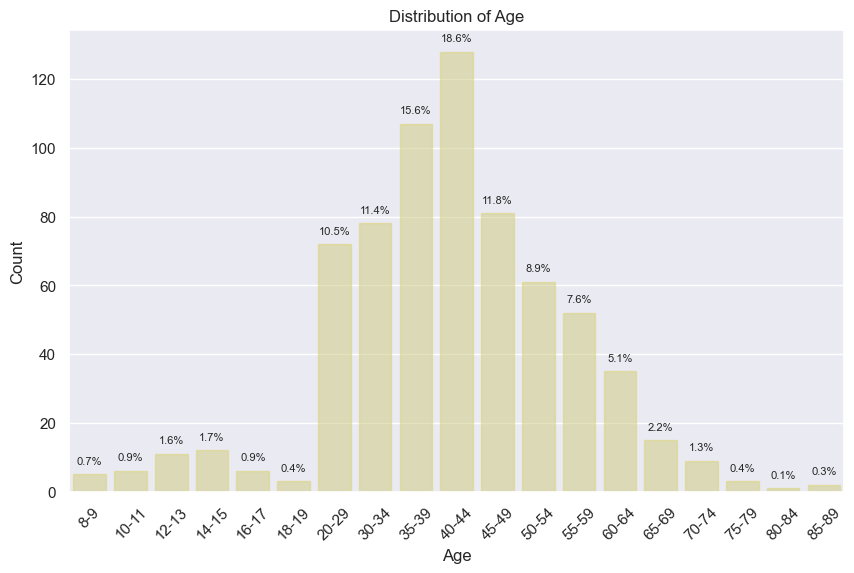

In [26]:
age_order = ['8-9','10-11','12-13','14-15','16-17','18-19','20-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89']

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Age', data=data, color='#DBD56E', order=age_order,alpha=0.5,linewidth=1, edgecolor='#DBD56E')

total_count = len(data['Age'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            f'{height/total_count:.1%}',
            ha='center', fontsize=8)

plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

We can see a quite symmetrical distribution with more than 50% of the participants in the age between 30 and 50.

Now we have a look at:

### Gender

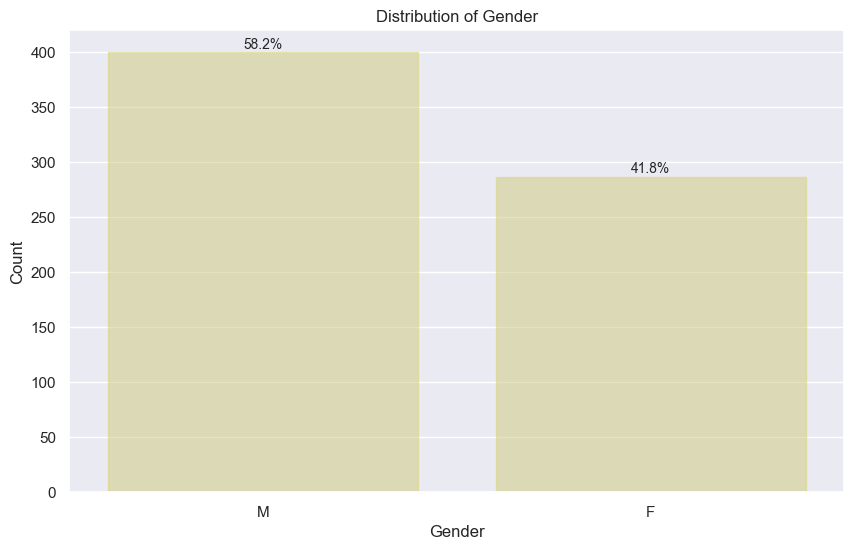

In [27]:
plt.figure(figsize=(10, 6))

ax = sns.countplot(x='Gender', data=data, color='#DBD56E',alpha=0.5,linewidth=1, edgecolor='#DBD56E')

total_count = len(data['Gender'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            f'{height/total_count:.1%}',
            ha='center', fontsize=10)

plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

There were more men in the race.

Now let's see which distance the participants ran:

### Distance

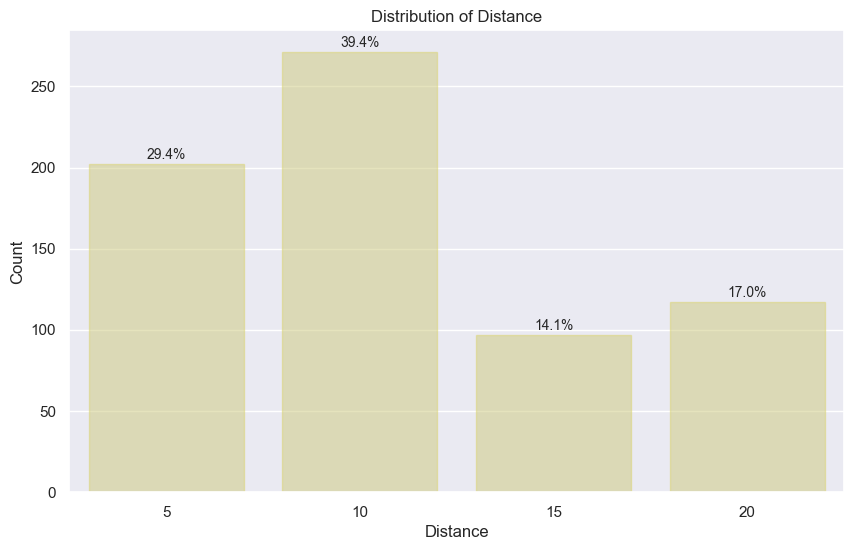

In [28]:
plt.figure(figsize=(10, 6))

ax = sns.countplot(x='Distance', data=data, color='#DBD56E',alpha=0.5,linewidth=1, edgecolor='#DBD56E')

total_count = len(data['Distance'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            f'{height/total_count:.1%}',
            ha='center', fontsize=10)

plt.title('Distribution of Distance')
plt.xlabel('Distance')
plt.ylabel('Count')

plt.show()

Most runners participated in the 10 km race.

I now want to check whether the runners were members of a running club or not.

### Club

First I have to change the values in that column a bit. We are not interested in the name of each club, but only the question: Club yes or no.

In [29]:
def change_club_values(row):
    if row['Club'] == 'Berlin':
        return 'No Club'
    else:
        return 'Club'

In [30]:
data['Club'] = data.apply(change_club_values, axis=1)

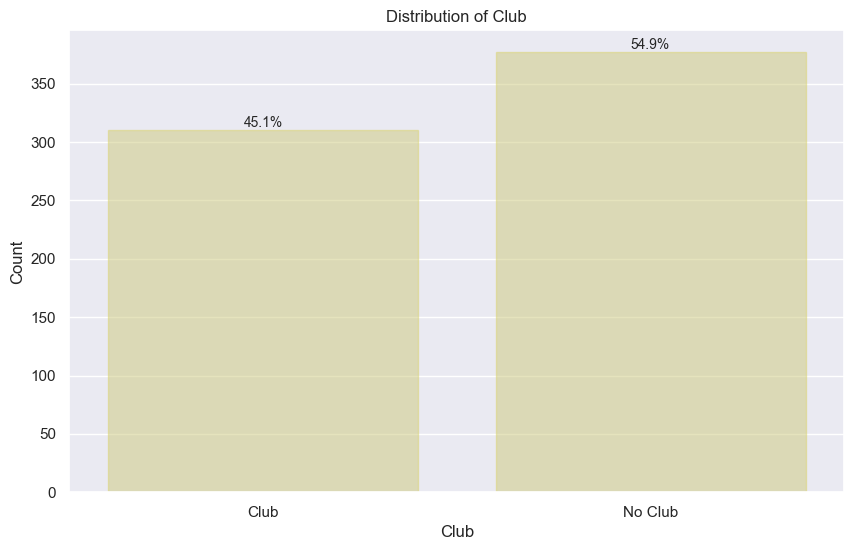

In [31]:
plt.figure(figsize=(10, 6))

ax = sns.countplot(x='Club', data=data, color='#DBD56E',alpha=0.5,linewidth=1, edgecolor='#DBD56E')

total_count = len(data['Club'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3, 
            f'{height/total_count:.1%}',
            ha='center', fontsize=10)

plt.title('Distribution of Club')
plt.xlabel('Club')
plt.ylabel('Count')

plt.show()

The were quite a lot of participants members in a (running) club.

### Net time (per distance)

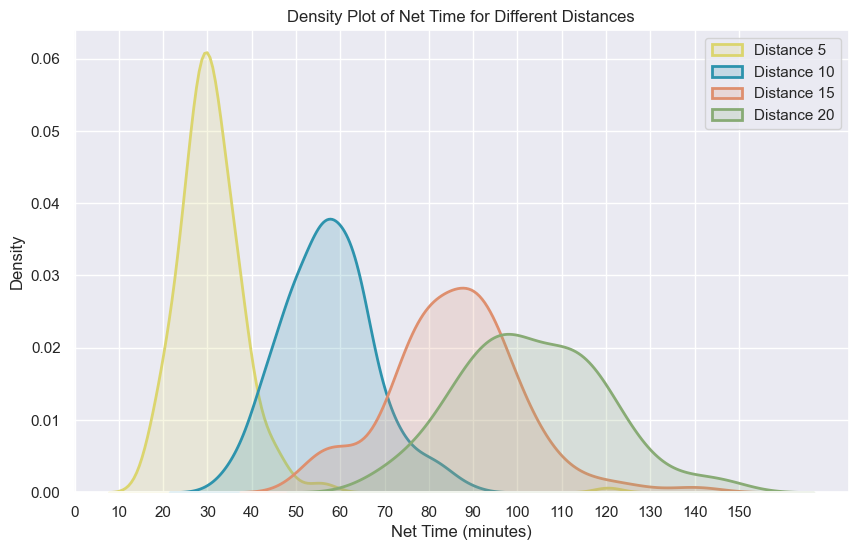

In [32]:
plt.figure(figsize=(10, 6))
distances = [5, 10, 15, 20]
colors = ["#DBD56E","#2D93AD","#DE8F6E","#88AB75"]  
for i, distance in enumerate(distances):
    df_net_time = data[data['Distance'] == distance].copy()
    df_net_time['Net_time_minutes'] = df_net_time['Net_time'].dt.total_seconds() / 60
    data.loc[data['Distance'] == distance, 'Net_time_minutes'] = df_net_time['Net_time_minutes']
    sns.kdeplot(df_net_time['Net_time_minutes'], color=colors[i], linewidth=2, fill=True, alpha=0.2, label=f'Distance {distance}')

plt.xlabel('Net Time (minutes)')

plt.title('Density Plot of Net Time for Different Distances')
plt.xticks(np.arange(0, df_net_time['Net_time_minutes'].max() + 10, 10))

plt.legend();

The shorter the distance, the more the net times are concentrated in a certain area. You can see this in the shape of the curve: The sharper and higher the curve, the smaller the variance of the distribution is. It's not surprising that variance increases as the distance increases: Differences in performance (in terms of pace) are more noticeable over longer distances.

You can also see that the runners are faster with incresing distance. If we still have a clear peak for 5 km at almost exactly 30 minutes (which corresponds to a pace of 6 min/km which is a typical value for recreational and occasional joggers), this shifts further and further forward as the distance increases, only slightly for 10 and 15 km but significantly for 20 km. Most runners manage the 20 km distance in under 120 minutes, which would correspond to a pace of 6 min/km. The reason is probably that well-trained (and therefore faster) runners are more likely to attempt the long distances.

Let's plot something similar for the

### Pace (per distance)

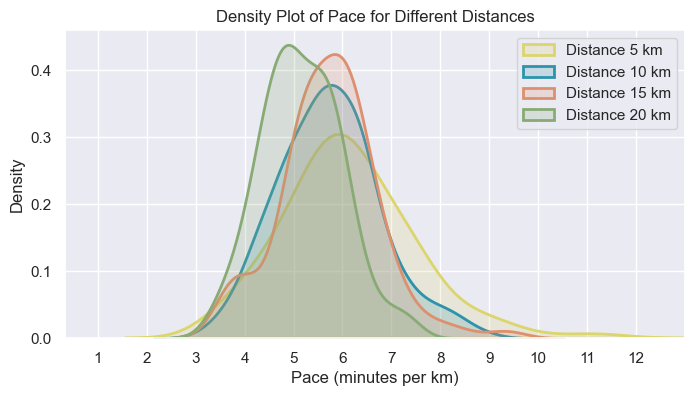

In [33]:
plt.figure(figsize=(8,4))
colors = ["#DBD56E","#2D93AD","#DE8F6E","#88AB75"]  
distances = [5, 10, 15, 20]
for i, distance in enumerate(data['Distance'].unique()):
    df_pace = data[data['Distance'] == distance].copy()
    
    df_pace.loc[:, 'Pace_minutes'] = df_pace['Pace'].dt.total_seconds() / 60
    
    sns.kdeplot(df_pace['Pace_minutes'], color=colors[i], linewidth=2, fill=True, alpha=0.2, label=f'Distance {distance} km')

plt.title('Density Plot of Pace for Different Distances')
plt.xlabel('Pace (minutes per km)')
plt.ylabel('Density')
plt.xlim(right=13)
plt.xticks(np.arange(1, 13, 1))

plt.legend()

plt.show();

First of all, we notice that the variance is more or less the opposite of what we saw before: the longer the distance, the more the curve seems to be concentrated around a certain value, for example slightly below 5 min/km for the 20 km runners. We see the greatest variance at the 5 km distance. Presumably a wider range of people registered for this distance. This distance is interesting for good runners because you can go very fast and also for comparatively weak runners because it is doable for them.

The expected value for the pace is almost the same for 10 and 15 km (slightly less than 5 min/km), although the variance for 15 km is slightly smaller.

This plot confirms what we already saw before when we had a look at the net times. I'd like to create another density plot for

### Pace (per gender)

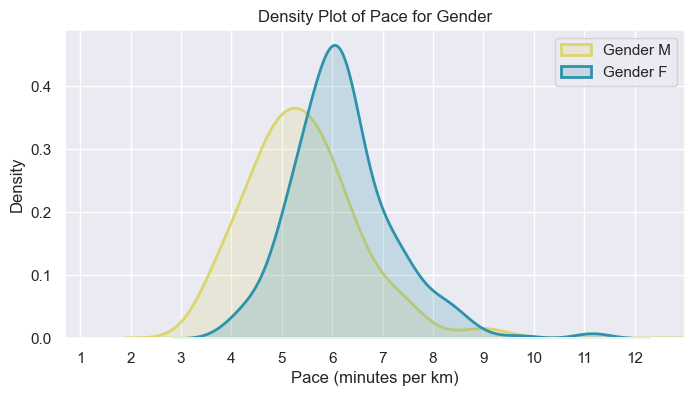

In [34]:
plt.figure(figsize=(8,4))
colors = ["#DBD56E","#2D93AD"]  
genders = ['M', 'F']
for i, gender in enumerate(data['Gender'].unique()):
    df_gender = data[data['Gender'] == gender].copy()
    
    df_gender.loc[:, 'Pace_minutes'] = df_gender['Pace'].dt.total_seconds() / 60
    
    sns.kdeplot(df_gender['Pace_minutes'], color=colors[i], linewidth=2, fill=True, alpha=0.2, label=f'Gender {gender}')

plt.title('Density Plot of Pace for Gender')
plt.xlabel('Pace (minutes per km)')
plt.ylabel('Density')
plt.xlim(right=13)
plt.xticks(np.arange(1, 13, 1))

plt.legend()

plt.show();

Men ran faster but there's also a greater variance in their pace values.

### Pace (per club membership)

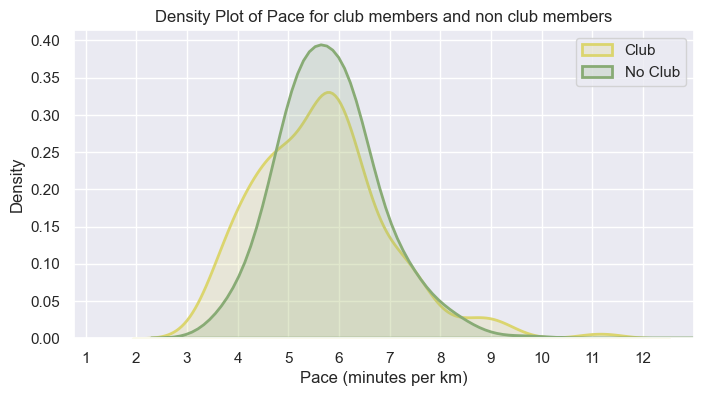

In [35]:
plt.figure(figsize=(8,4))
colors = ["#DBD56E","#88AB75"]  
clubs = ['Club', 'No Club']
for i, club in enumerate(data['Club'].unique()):
    df_clubs = data[data['Club'] == club].copy()
    
    df_clubs.loc[:, 'Pace_minutes'] = df_clubs['Pace'].dt.total_seconds() / 60
    
    sns.kdeplot(df_clubs['Pace_minutes'], color=colors[i], linewidth=2, fill=True, alpha=0.2, label=f'{club}')

plt.title('Density Plot of Pace for club members and non club members')
plt.xlabel('Pace (minutes per km)')
plt.ylabel('Density')
plt.xlim(right=13)
plt.xticks(np.arange(1, 13, 1))

plt.legend()

plt.show();

The distribution of the pace of non-members of a running club almost looks like a perfect normal distribution. 

The distribution of members, on the other hand, looks clearly skewed to the right. There are a lot of observations in the left area (low pace) but on the right a tail of values in the positive extreme.

Nonetheless, club members have the higher density at a similar pace as the non-members.

### Pace (per age)

The compare the pace per age, I'll use boxplots and won't show the outliers.

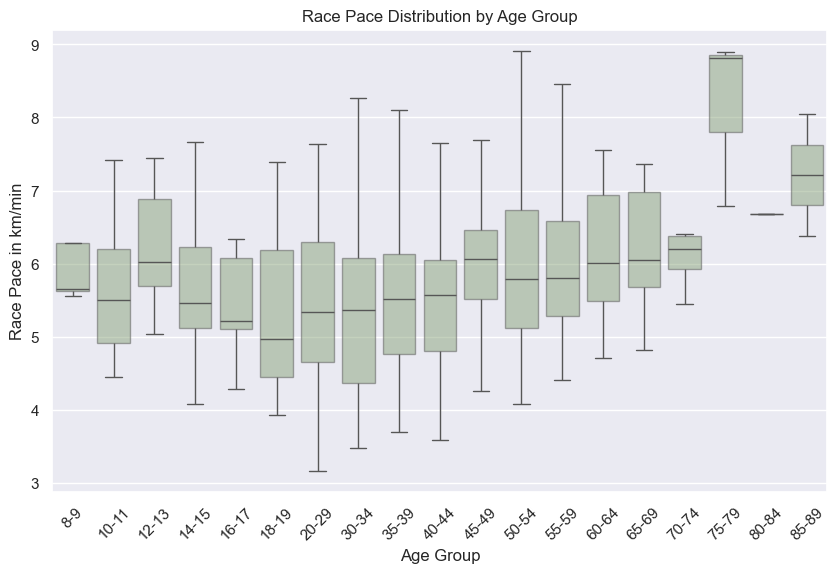

In [36]:
data['Pace_minutes'] = data['Pace'].dt.total_seconds() / 60
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Age', y='Pace_minutes', data=data, color="#88AB75", order=age_order, boxprops=dict(alpha=.5), showfliers = False)
plt.title('Race Pace Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Race Pace in km/min')
plt.xticks(rotation=45)

plt.show()

I won't go into too much detail here, especially as the plots for some age groups with extremely few participants are only meaningful to a limited extent.

Just a quick word about box plots in general: The green area shows the range in which the middle 50% of the values lie. The upper and lower whiskers show the maximum and minimum values (in this case without outliers, removed using the IQR method). The black line in the middle shows the median value of the age group.

Very compressed boxplots indicate a low variance in the age group - but this may also be due to the fact that there are simply not many observations!

I think, you can see a certain trend. The pace values tend to decrease up to a certain age and then increase again from the mid-30s. I think it makes sense that the greatest performance is achieved in young adulthood, although the variance in these age groups is very high (which is also due to the large number of participants).

### Pace in general

Let's also have a distribution of pace, independent of other variables for the sake of completeness.

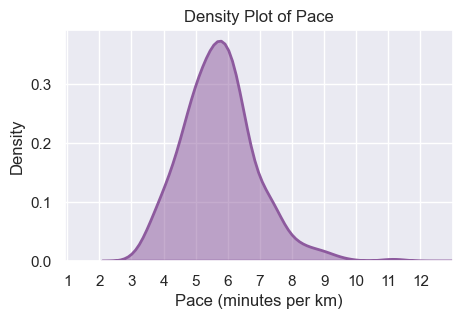

In [37]:
plt.figure(figsize=(5,3))

sns.kdeplot(data['Pace_minutes'], color='#8D5A9E', linewidth=2, fill=True, alpha=0.5)

plt.title('Density Plot of Pace')
plt.xlabel('Pace (minutes per km)')
plt.ylabel('Density')
plt.xlim(right=13)
plt.xticks(np.arange(1, 13, 1))

plt.show();

We don't see any surprises in this plot.

Let's now check which distances the different age groups ran.

### Distance per Age:

In [38]:
age_distance = pd.crosstab(data['Age'], data['Distance'])
age_distance = age_distance.reindex(age_order)

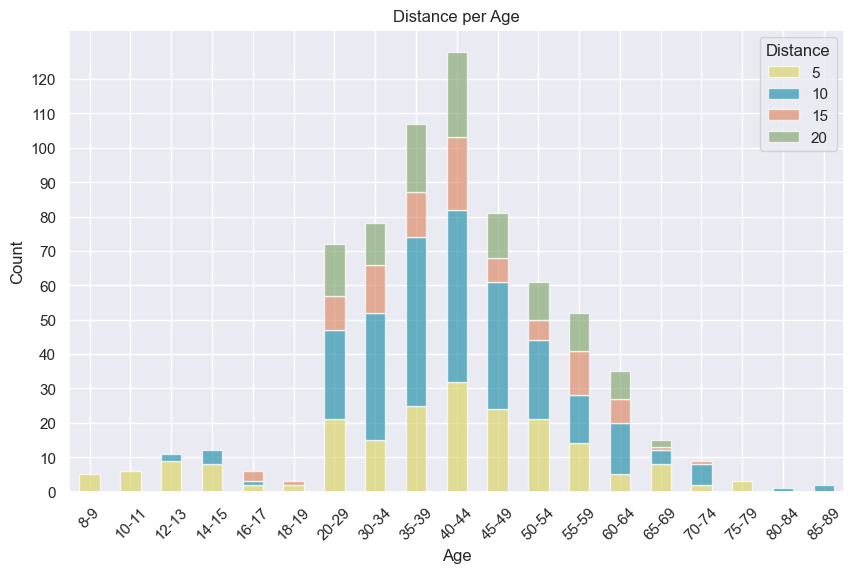

In [39]:
age_distance.plot(kind='bar', stacked=True, color=c_pal, alpha=.7, figsize=(10,6))
plt.title('Distance per Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,130,10))

plt.show();

We see that children tend to run short distances. The longer distances (15 or 20 km) were particularly interesting in middle adulthood. Once again, we see that 10 and 5 km were the most popular distances.

In [40]:
gender_distance = pd.crosstab(data['Gender'], data['Distance'])

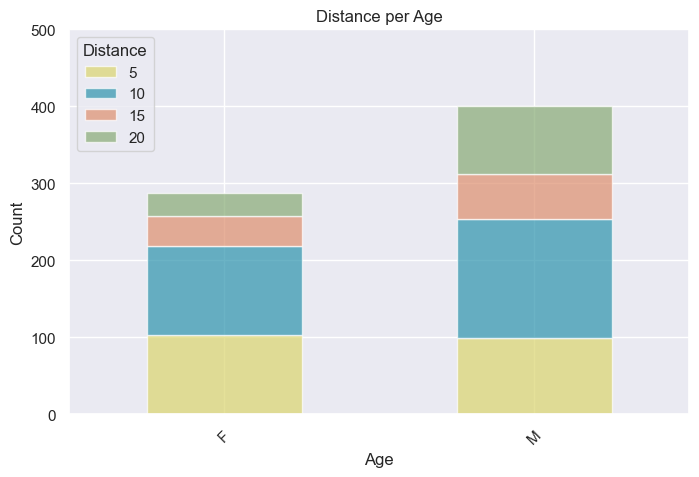

In [41]:
gender_distance.plot(kind='bar', figsize=(8,5), stacked=True, color=c_pal, alpha=.7)
plt.title('Distance per Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,600,100))

plt.show();

While roughly the same number of men and women took part in the 5 km race, more and more men were taking part in the longer distances.

# Conclusions

I think we have gained some interesting insights, but the data set is very limited. I tried a few more things, but have deleted them again: for example, a cluster model (unsupervised learning) - but this didn't produce anything "cool" due to the poor data situation. 

I also looked separately at the data only for the 10 km distance because I ran this distance myself. But the methods and results differ little from what we have already seen. And it is not my intention to bore anyone looking at this notebook.

I also tried a few alternative visualizations, e.g. Treemap (I'll show you in a moment), but honestly I think that in this case the good old bar chart is more intuitive to understand.

So what can we conclude from the data?

I don't think it's anything too surprising for anyone who is a bit into running. Basically, it's suitable for everyone. People from 8 to 85+ years old took part in this run. I think that's pretty cool. Yes, the best times were achieved by young men between 20 and 30. But if you are well trained, you can still achieve amazing feats at an older age. For example, there was a man in the race who, at 85+, ran the 10 km in (brace yourselves!) under 64 minutes. How do I know that? I'll put a heat map below showing the best times based on age/gender group and distance.

By the way, I myself ran below average for my age and gender. However, I hadn't trained at all and was ill for 6 weeks before the race. 

Never mind, it was still fun and the data set was a nice playground for me.

Here is the treemap about distance:

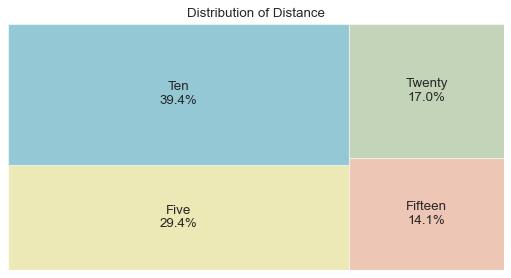

In [42]:
def custom_label(value):
    if value == 5:
        return 'Five'
    elif value == 10:
        return 'Ten'
    elif value == 15:
        return 'Fifteen'
    elif value == 20:
        return 'Twenty'

df = data.groupby('Distance').size().reset_index(name='counts')
total_counts = df['counts'].sum()
df['percentage'] = (df['counts'] / total_counts) * 100

labels = df.apply(lambda x: f"{custom_label(x.iloc[0])}\n{x['percentage']:.1f}%", axis=1)
sizes = df['counts'].values.tolist()

plt.figure(figsize=(8,4), dpi=80)
squarify.plot(sizes=sizes, label=labels, color=c_pal, alpha=.5)

plt.title('Distribution of Distance')
plt.axis('off')
plt.show()

It may look more modern or at least different, but I don't think it's any better than the classic bargraph.

Now I show you this heatmap of best times based on age/gender group and distance. 

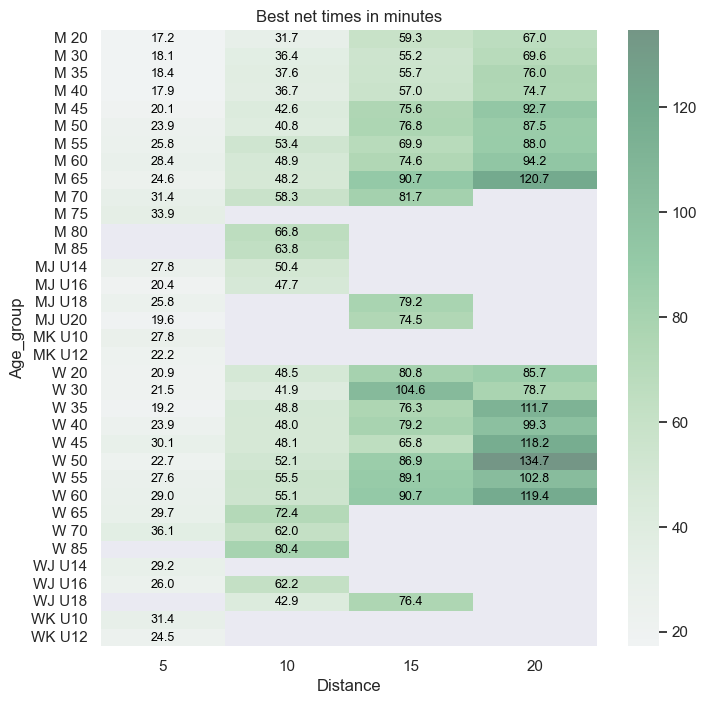

In [43]:
sns.set_style({'axes.grid' : False})
data['Net_time_minutes'] = pd.to_timedelta(data['Net_time']).dt.total_seconds() / 60

pivot_table = pd.pivot_table(data, values='Net_time_minutes', index='Age_group', columns='Distance', aggfunc='min')
plt.figure(figsize=(8,8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='Greens', annot_kws={"color": "black", "fontsize":9}, alpha=.5)
plt.title('Best net times in minutes')
plt.xlabel('Distance')
plt.ylabel('Age_group')
plt.show()

I'll adjust the colors a bit more when I get the chance. I have a more customized solution in mind, where I determine the color for each range myself.

But i still didn't want to withhold the table from you, even if it doesn't yet look the way I want it to. 

Because in it you can see so well what is possible in running!